## PS3 QUANTITATIVE MACROECONOMICS 

### Jorge Batanero

In [340]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import timeit
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Value Function Iteration

Consider a stationary economy populated by a large number of identical infinitely lived households that maximize:

\begin{align}
    \mathbf{E}_0\left\{ \sum_{t=0}^\infty \beta^t u(c_t,h_t)\right\}
\end{align}

over consumption and leisure $u(c_t,h_t)=lnc_t -\kappa \frac{h_t^{1+\frac{1}{\nu}}}{1+\frac{1}{\nu}}$ subject to:

\begin{align}
    c_t+i_t=y_t \\
    y_t=k_t^{1-\theta}h_t^{\theta} \\
    i_t=k_{t+1}-(1-\delta)k_t
\end{align}

Set $\theta=0.679$, $\beta=0.988$, $\delta=0.13$. Also start with, set $h_t=1$, that is labor is inelastically supplied. To compute steady state normalize output to one.

\textbf{a) Solve with brute force iterations of the value function. Plot your value function.}

Using $h_t=1$ then $c_t=k_t^{1-\theta}+(1-\delta)k_t-k_{t+1}$, replacing $c_t$ in the utility function we can write the problem in recursive formulation as follows:

\begin{equation*}
	\begin{aligned}
	& V(k)= \underset{(k') \in \Gamma (k)}{\max}
	& & u(k^{1-\theta}+(1-\delta)k-k') + \beta  V(k')\\
	& \text{where}
	& & \Gamma(k)=\{(k'):0 \le k'\le k^{1-\theta}+(1-\delta)k\}  
	\end{aligned}
	\end{equation*}

In [330]:
#Set the value of the known parameters: 
θ = 0.679
β = 0.988
δ = 0.013
κ = 5.24
ν = 2
h = 1 
n=150

# STEP 1: DISCRETIZE THE CONTINUOUS VARIBLE k. 
k_ss=(1/(1-θ)*((1/β)+δ-1))**(-1/θ)
k=np.linspace(0.1,1.5*k_ss,n)#evenly spaced grid. 

#STEP 2: Initial guess, null vector
V = np.zeros(shape=[1,n])

#STEP 3: Feasible return matrix (M).
#  Combinations of levels of capital today and tomorrow such that the consumption is non negative
def non_negativity(ki,kj):
    "Returns the combinations of k_t and k_{t+1} such that consumption is non-negative"
    return ki**(1-θ)+ (1-δ)*ki-kj

# Compute the utility for each level of capital
def u(ki,kj):
    "Returns the utility"
    return np.log(ki**(1-θ)+ (1-δ)*ki - kj) - (κ/(1+(1/ν)))
    

# Define the feasible return matrix
M = np.zeros(shape=(n,n))    
for i in range(n):
    for j in range(n):
        if non_negativity(k[i],k[j]) >= 0: 
            M[i][j] = u(k[i],k[j])    # Gives the element ij of matrix M
        else: 
            M[i][j] = -1000  # STEP 4: Replace non feasible values of M by a high negative number
# If we have a NaN on the matrix M this implies that the non negativity constraint
# was not satisfies for the pair ki, kj, thefore I replace this NaN by a high negative 
# number to be sure that this won't be part of the optimal solution


Number of iterations 462
Program Executed in 11.57


Text(0.5, 1.0, 'Brute Force Policy Function')

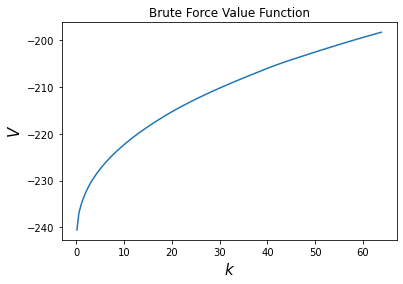

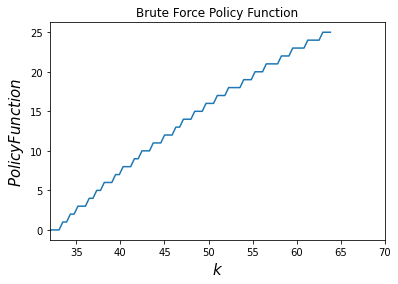

In [338]:
# A) BRUTE FORCE

start = timeit.default_timer()

def ValueIteration(M,V):
    "This function returns the solution for the Bellman equation"
    ϵ = 0.01      # Tolerance 
    χ = np.zeros(shape=(n,n))     # Array χ
    V_new = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    g=np.zeros(shape=(1,n))
     #STEP 5.1 COMPUTE χ    
    for i in range(n):
        for j in range(n):
            χ[i][j] = M[i][j] + β*V[0][j]
    #STEP 5.2 Compute the update V as the max of every row i of χ
    for i in range(n):
        V_new[0][i] = np.amax(χ[i][:])     # New iteration for V
        g[0][i]=np.argmax(χ[i][:])
    count=0                                 # count the number of iterations
    while np.any(abs(V-V_new>= ϵ)):    # continue the loop if the distance is higher than ϵ
        V = V_new.copy()
        for i in range(n):
            for j in range(n):         
                χ[i][j] = M[i][j] + β*V_new[0][j]
        for i in range(n):    
            V_new[0][i] = np.amax(χ[i][:])
            g[0][i]=np.argmax(χ[i][:])
        count +=1
 
    print('Number of iterations '+str(count))    
    return V

ValueFunction =np.transpose(ValueIteration(M,V))
stop = timeit.default_timer()
execution_time = stop - start
execution_time=round(execution_time,2)
print('Program Executed in', execution_time) #It returns time in sec


# Plot:
fig, ax = plt.subplots()
ax.plot(k,ValueFunction)
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.title("Brute Force Value Function")

fig, ax = plt.subplots()
ax.plot(k,g)
plt.ylabel("$Policy Function$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.xlim(32,70)
plt.title("Brute Force Policy Function")

Number of iterations 462
Program Executed in 9.91


Text(0.5, 1.0, 'Using Monotonicity Policy Function')

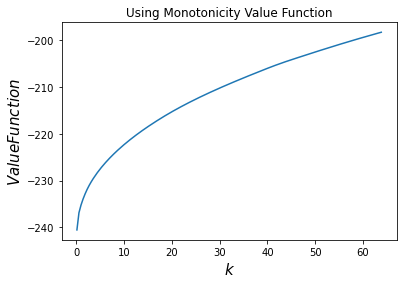

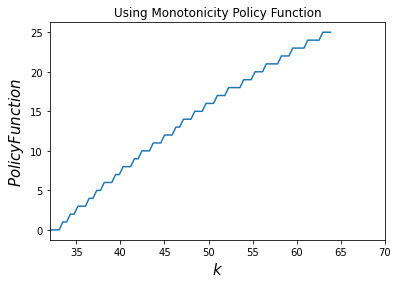

In [287]:
# B using the monotonicity of the policy function
start = timeit.default_timer()

def ValueIterationB(M,V):
    "This function returns the solution for the Bellman equation"
    ϵ = 0.01      # Tolerance 
    χ = np.zeros(shape=(n,n))     # Array χ
    V_new = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    g = np.zeros(shape=(1,n)) # Array optimal policy
     #STEP 5.1 COMPUTE χ    
    for i in range(n):
        for j in range(n):
            χ[i][j] = M[i][j] + β*V[0][j]
    #STEP 5.2 Compute the update V as the max of every row i of χ
    for i in range(n):
        V_new[0][i] = np.amax(χ[i][:])     # New iteration for V
        g[0][i]=np.argmax(χ[i][:]) # Return the number of the column j that maximices every i 
    count=0                                 # count the number of iterations
    while np.any(abs(V-V_new>= ϵ)):    # continue the loop if the distance is higher than ϵ
        V = V_new.copy()
        χ=np.ones(shape=(n,n))*(-1000)
        for i in range(n):
            search  = np.int_(np.linspace(np.int_(g[0][i]),n-1,n-np.int_(g[0][i])))
            for j in search:         
                χ[i][j] = M[i][j] + β*V_new[0][j]
        for i in range(n):    
            V_new[0][i] = np.amax(χ[i][:])
            g[0][i]= np.argmax(χ[i][:])
        count +=1
 
    print('Number of iterations '+str(count))    
    return V


ValueFunctionB =np.transpose(ValueIterationB(M,V))

stop = timeit.default_timer()
execution_time = stop - start
execution_time=round(execution_time,2)
print('Program Executed in', execution_time) #It returns time in sec


# Plot:
fig, ax = plt.subplots()
ax.plot(k,ValueFunctionB)
plt.ylabel("$Value Function$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.title("Using Monotonicity Value Function")


fig, ax = plt.subplots()
ax.plot(k,g)
plt.ylabel("$Policy Function$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.xlim(32,70)
plt.title("Using Monotonicity Policy Function")


Number of iterations 0
Program Executed in 101.34


Text(0.5, 1.0, 'Value Function')

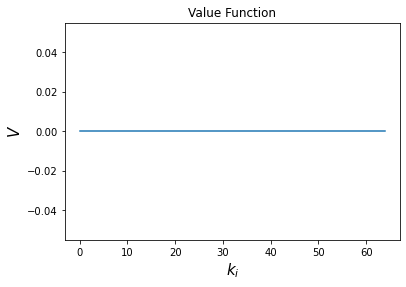

In [272]:
# C Iterations of the value function taking into account concavity of the value function.
start = timeit.default_timer()

def ValueIterationC(M,V):
    "This function returns the solution for the Bellman equation"
    ϵ = 0.01      # Tolerance 
    χ = np.zeros(shape=(n,n))     # Array χ
    V_new = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
     #STEP 5.1 COMPUTE χ    
    for i in range(n):
        for j in range(n):
            if χ[i,j]>χ[i,j-1]: # Here I'm applying concavity, don't kwon why is not working
                χ[i][j] = M[i][j] + β*V[0][j]
    #STEP 5.2 Compute the update V as the max of every row i of χ
    for i in range(n):
        V_new[0][i] = np.amax(χ[i][:])     # New iteration for V
    count=0                                 # count the number of iterations
    while np.any(abs(V-V_new>= ϵ)):    # continue the loop if the distance is higher than ϵ
        V = V_new.copy()
        for i in range(n):
            for j in range(n):  
                χ[i][j] = M[i][j] + β*V_new[0][j]
        for i in range(n):    
            V_new[0][i] = np.amax(χ[i][:])
        count +=1
 
    print('Number of iterations '+str(count))    
    return V

ValueFunctionC =np.transpose(ValueIterationC(M,V))

stop = timeit.default_timer()
execution_time = stop - start
execution_time=round(execution_time,2)
print('Program Executed in', execution_time) #It returns time in sec


# Plot:
fig, ax = plt.subplots()
ax.plot(k,ValueFunction1)
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function")

Number of iteraionts: 461
Program Executed in 3.34


Text(0.5, 1.0, 'Local Search Policy Function')

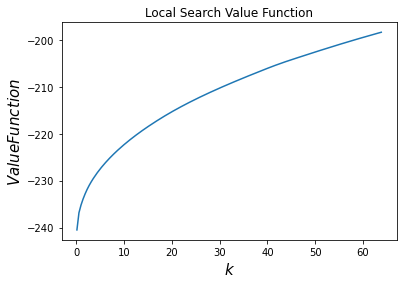

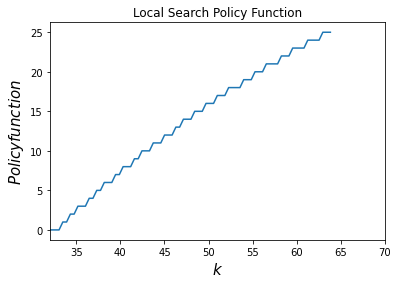

In [288]:
# D Iterations of the value function taking into account local search on the decision rule
start = timeit.default_timer()

def ValueIterationD(M,V):
    "This function returns the solution for the Bellman equation"
    ϵ = 0.01      # Tolerance 
    χ = np.zeros(shape=(n,n))     # Array χ
    V_new = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    g = np.zeros(shape=(1,n)) # Array optimal policy
    k = 3   # Will define the size of the set of neigborhoods. Size = 2k
     #STEP 5.1 COMPUTE χ    
    for i in range(n):
        for j in range(n):
            χ[i][j] = M[i][j] + β*V[0][j]
    #STEP 5.2 Compute the update V as the max of every row i of χ
    for i in range(n):
        V_new[0][i] = np.amax(χ[i][:])     # New iteration for V
        g[0][i]=np.argmax(χ[i][:]) # Return the number of the column j that maximices every i 
    count=0                                 # count the number of iterations
    while np.any(abs(V-V_new>= ϵ)):    # continue the loop if the distance is higher than ϵ
        V = V_new.copy()
        χ=np.ones(shape=(n,n))*(-1000)
        for i in range(n): 
            # Generate a grid for neighborhoods search: (more conditions need to be added if we change k)
            # Sergi helped me with this part of the code
            if g[0][i] == 0:
                neigh = np.int_(np.linspace(0,2*k,2*k+1))
            if g[0][i] == 1:
                 neigh = np.int_(np.linspace(0,2*k,2*k+1))
            if g[0][i] == 2:
                neigh = np.int_(np.linspace(0,2*k,2*k+1))
            if g[0][i]>2:
                neigh = np.int_(np.linspace(g[0][i]-k,g[0][i]+k,2*k+1))
            if g[0][i] == n-1:
                neigh = np.int_(np.linspace(n-1-2*k,n-1,2*k+1))
            if g[0][i] == n-2:
                neigh = np.int_(np.linspace(n-1-2*k,n-1,2*k+1))
            if g[0][i] == n-3:
                neigh = np.int_(np.linspace(n-1-2*k,n-1,2*k+1))
                
            for j in neigh:     # Just search on neighborhoods
                
                    χ[i][j] = M[i][j] + β*V_new[0][j]
                                    
        for i in range(n):    
            V_new[0][i] = np.amax(χ[i][:])
            g[0][i] = np.argmax(χ[i][:])
        count +=1
    print('Number of iteraionts: '+str(count))
    
    return V

ValueFunctionD =np.transpose(ValueIterationD(M,V))

stop = timeit.default_timer()
execution_time = stop - start
execution_time=round(execution_time,2)
print('Program Executed in', execution_time) #It returns time in sec


# Plot:
fig, ax = plt.subplots()
ax.plot(k,ValueFunctionD)
plt.ylabel("$Value Function$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.title("Local Search Value Function")

fig, ax = plt.subplots()
ax.plot(k,g)
plt.ylabel("$Policy function$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.xlim(32,70)
plt.title("Local Search Policy Function")

Number of iterations 0
Program Executed in 3.85


Text(0.5, 1.0, 'Value Function')

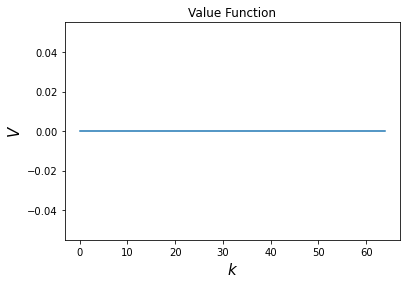

In [259]:
# E start = timeit.default_timer()

def ValueIterationE(M,V):
    "This function returns the solution for the Bellman equation"
    ϵ = 0.01      # Tolerance 
    χ = np.zeros(shape=(n,n))     # Array χ
    V_new = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    g = np.zeros(shape=(1,n)) # Array optimal policy
     #STEP 5.1 COMPUTE χ    
    for i in range(n):
        for j in range(n):
            if χ[i,j]>χ[i,j-1]:
                χ[i][j] = M[i][j] + β*V[0][j]
    #STEP 5.2 Compute the update V as the max of every row i of χ
    for i in range(n):
        V_new[0][i] = np.amax(χ[i][:])     # New iteration for V
        g[0][i]=np.argmax(χ[i][:]) # Return the number of the column j that maximices every i 
    count=0                                 # count the number of iterations
    while np.any(abs(V-V_new>= ϵ)):    # continue the loop if the distance is higher than ϵ
        V = V_new.copy()
        χ=np.ones(shape=(n,n))*(-1000)
        for i in range(n):
            search  = np.int_(np.linspace(np.int_(g[0][i]),n-1,n-np.int_(g[0][i])))
            for j in search:         
                χ[i][j] = M[i][j] + β*V_new[0][j]
        for i in range(n):    
            V_new[0][i] = np.amax(χ[i][:])
            g[0][i]= np.argmax(χ[i][:])
        count +=1
 
    print('Number of iterations '+str(count))    
    return V


ValueFunctionE =np.transpose(ValueIterationE(M,V))

stop = timeit.default_timer()
execution_time = stop - start
execution_time=round(execution_time,2)
print('Program Executed in', execution_time) #It returns time in sec


# Plot:
fig, ax = plt.subplots()
ax.plot(k,ValueFunctionE)
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.title("Value Function")



Number of iterations 462
Program Executed in 12.18


Text(0.5, 1.0, 'Howard Policy Function 50 Steps')

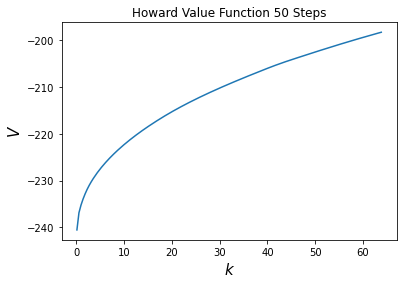

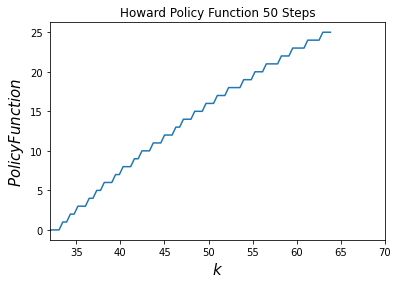

In [323]:
# F Use Howard's policy iterations waiting until converged to solve the problem.
# G Use policy iterations with 5, 10, 20 and 50 steps in between policy reassessments.
start = timeit.default_timer()

def ValueIterationH(M,V,p):
    "This function returns the solution for the Bellman equation"
    ϵ = 0.01      # Tolerance 
    χ = np.zeros(shape=(n,n))     # Array χ
    V_new = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    g=np.zeros(shape=(1,n))
     #STEP 5.1 COMPUTE χ    
    for i in range(n):
        for j in range(n):
            χ[i][j] = M[i][j] + β*V[0][j]
    #STEP 5.2 Compute the update V as the max of every row i of χ
    for i in range(n):
        V_new[0][i] = np.amax(χ[i][:])     # New iteration for V
        g[0][i]=np.argmax(χ[i][:])
    count=0 # count the number of iterations
    policy=0 # count the number of iterations
    while np.any(abs(V-V_new>= ϵ)):    # continue the loop if the distance is higher than ϵ
        V = V_new.copy()
        for i in range(n):
            for j in range(n):         
                χ[i][j] = M[i][j] + β*V_new[0][j]
        for i in range(n): 
            g[0][i]=np.argmax(χ[i][:])
            V_new[0][i] = np.amax(χ[i][np.int_(g[0][i])])  
        count +=1
        policy +=1
        
        if policy == p:
            for i in range(n):
                g[0][i]=np.argmax(χ[i][:])
                policy = 0
        else:
            continue
 
    print('Number of iterations '+str(count))    
    return V

p=50

ValueFunctionH =np.transpose(ValueIterationH(M,V,p))

stop = timeit.default_timer()
execution_time = stop - start
execution_time=round(execution_time,2)
print('Program Executed in', execution_time) #It returns time in sec


# Plot:
fig, ax = plt.subplots()
ax.plot(k,ValueFunctionH)
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.title("Howard Value Function 50 Steps")

fig, ax = plt.subplots()
ax.plot(k,g)
plt.ylabel("$Policy Function$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.xlim(32,70)
plt.title("Howard Policy Function 50 Steps")

In [349]:
# 2 repeat with endogenous labor 

#Set the value of the known parameters: 
θ = 0.679
β = 0.988
δ = 0.013
κ = 5.24
ν = 2
n=150
m=10
start = timeit.default_timer()
# STEP 1: DISCRETIZE THE CONTINUOUS VARIBLE k. 
# By properties of the C-D we know that k and h are complements
# since the higher value that h can take is 1, we can use the same discrite 
# space for k since the h of steady state at most can be 1
k_ss=(1/(1-θ)*((1/β)+δ-1))**(-1/θ)
k=np.linspace(0.1,1.5*k_ss,n)#evenly spaced grid for capital. 
h=np.linspace(0,1,m) #evenly spaced grid for labor

#STEP 2: Initial guess, null vector
V = np.zeros(shape=[1,n])

#STEP 3: Feasible return matrix (M).
#  Combinations of levels of capital today and tomorrow such that the consumption is non negative
def non_negativity(ki,kj,h):
    "Returns the combinations of k_t and k_{t+1} such that consumption is non-negative"
    return ki**(1-θ)*h**(θ)+ (1-δ)*ki-kj

# Compute the utility for each level of capital
def u(ki,kj,h):
    "Returns the utility"
    return np.log(ki**(1-θ)*h**(θ)+ (1-δ)*ki - kj) - (κ*(h**(1+(1/ν)))/(1+(1/ν)))
    
# Define the feasible return matrix
M = np.zeros(shape=(n,n,m))    
for i in range(n):
    for j in range(n):
        for s in range(m):
            if non_negativity(k[i],k[j],h[s]) >= 0: 
                M[i][j][s] = u(k[i],k[j],h[s])    # Gives the element ijs of matrix M
            else: 
                M[i][j][s] = -1000  # STEP 4: Replace non feasible values of M by a high negative number
# If we have a NaN on the matrix M this implies that the non negativity constraint
# was not satisfied by ki, kj, h, thefore I replace this NaN by a high negative 
# number to be sure that this won't be part of the optimal solution


Number of iterations 377
Program Executed in 127.87


Text(0.5, 1.0, 'Policy Function')

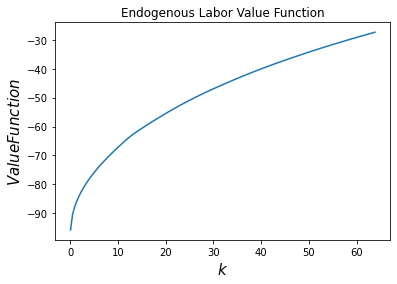

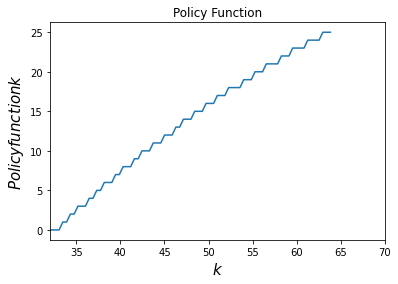

In [348]:
# 2a Brute Force
def ValueIteration2(M,V):
    "This function returns the solution for the Bellman equation"
    ϵ = 0.01      # Tolerance 
    χ = np.zeros(shape=(n,n,m))     # Array χ
    V_new = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    g= np.zeros(shape=(1,n))
     #STEP 5.1 COMPUTE χ    
    for i in range(n):
        for j in range(n):
            for s in range(m):
                χ[i][j][s] = M[i][j][s] + β*V[0][j]
    #STEP 5.2 Compute the update V as the max of every row i of χ
    for i in range(n):
        V_new[0][i] = np.amax(χ[i][:][:]) # New iteration for V
        for s in range(m):
            g[0][i]= np.argmax(χ[i][:][s]) # Policy for capital 
    count=0                                 # count the number of iterations
    while np.any(abs(V-V_new>= ϵ)):    # continue the loop if the distance is higher than ϵ
        V = V_new.copy()
        for i in range(n):
            for j in range(n):
                for s in range(m):
                    χ[i][j][s] = M[i][j][s] + β*V_new[0][j]
        for i in range(n):    
            V_new[0][i] = np.amax(χ[i][:][:])
        count +=1
 
    print('Number of iterations '+str(count))    
    return V

ValueFunction2 =np.transpose(ValueIteration2(M,V))

stop = timeit.default_timer()
execution_time = stop - start
execution_time=round(execution_time,2)
print('Program Executed in', execution_time) #It returns time in sec


# Plot:
fig, ax = plt.subplots()
ax.plot(k,ValueFunction2)
plt.ylabel("$Value Function$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.title("Endogenous Labor Value Function")

fig, ax = plt.subplots()
ax.plot(k,g)
plt.ylabel("$Policy function k$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.xlim(32,70)
plt.title("Policy Function")

Number of iterations 377
Program Executed in 149.17


Text(0.5, 1.0, 'Monotonicity Policy Function')

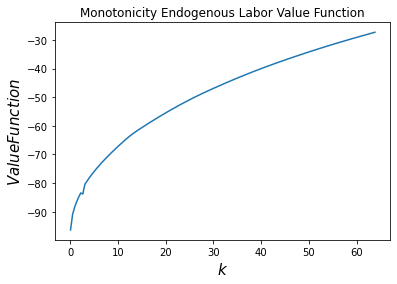

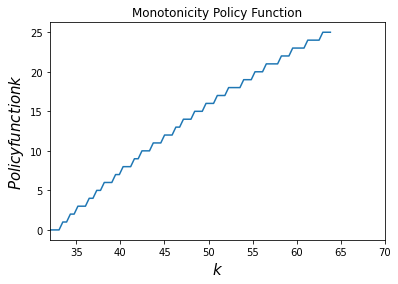

In [350]:
# 2B using monotonicity
def ValueIteration2B(M,V):
    "This function returns the solution for the Bellman equation"
    ϵ = 0.01      # Tolerance 
    χ = np.zeros(shape=(n,n,m))     # Array χ
    V_new = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    g= np.zeros(shape=(1,n))
     #STEP 5.1 COMPUTE χ    
    for i in range(n):
        for j in range(n):
            for s in range(m):
                χ[i][j][s] = M[i][j][s] + β*V[0][j]
    #STEP 5.2 Compute the update V as the max of every row i of χ
    for i in range(n):
        V_new[0][i] = np.amax(χ[i][:][:]) # New iteration for V
        for s in range(m):
            g[0][i]= np.argmax(χ[i][:][s]) # Policy for capital
    count=0                                 # count the number of iterations
    while np.any(abs(V-V_new>= ϵ)):    # continue the loop if the distance is higher than ϵ
        V = V_new.copy()
        χ=np.ones(shape=(n,n,m))*(-1000)
        for i in range(n):
            search  = np.int_(np.linspace(np.int_(g[0][i]),n-1,n-np.int_(g[0][i])))
            for j in search: 
                for s in range(m):
                    χ[i][j][s] = M[i][j][s] + β*V_new[0][j]
        for i in range(n):    
            V_new[0][i] = np.amax(χ[i][:][:])
            for s in range(m):
                g[0][i]= np.argmax(χ[i][:][s])
        count +=1
 
    print('Number of iterations '+str(count))    
    return V


ValueFunction2B =np.transpose(ValueIteration2B(M,V))

stop = timeit.default_timer()
execution_time = stop - start
execution_time=round(execution_time,2)
print('Program Executed in', execution_time) #It returns time in sec


# Plot:
fig, ax = plt.subplots()
ax.plot(k,ValueFunction2B)
plt.ylabel("$Value Function$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.title("Monotonicity Endogenous Labor Value Function")

fig, ax = plt.subplots()
ax.plot(k,g)
plt.ylabel("$Policy function k$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.xlim(32,70)
plt.title("Monotonicity Policy Function")

Program Executed in: 19.82 seconds
Number of iterations:  315


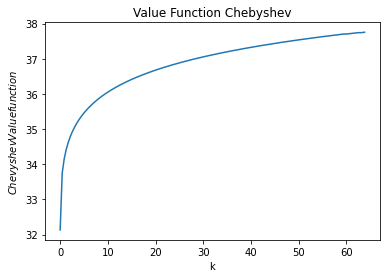

Text(0.5, 1.0, 'Chevyshev Policy Function')

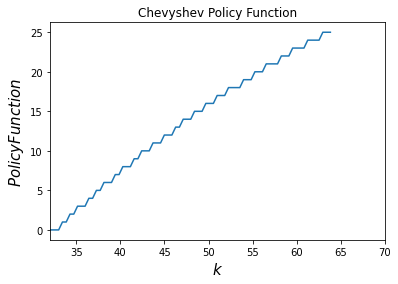

In [294]:
# 3 repeat 1 with Chebyshev 
import numpy as np
import matplotlib.pyplot as plt
import timeit
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


#STEP 1: Set the order of polynomials used for approximation.
n=2

#STEP 2: Set the tolerance parameter
ε=0.01

#STEP 3: Upper and lower bound of the discrete space state
β=0.988   
θ=.679
δ=.013
κ=5.24
ν=2
k_ss=(1/(1-θ)*((1/β)+δ-1))**(-1/θ)
n3=150
k=np.linspace(0.01,1.5*k_ss,n3) #evenly spaced grid. 

#STEP 4: Compute the collocations nodes. 
# a) Cheby nodes [-1,1]
nodes=np.zeros(shape=(n3,))
for i in range(n3):
    nodes[i]=np.cos((((2*i)-1)/300)*np.pi)
 

    
#b) Adjust the nodes to the [k0,1.5*k_ss] interval:
nod=np.zeros(shape=(n3,))
for i in range(n3):
    nod[i]=((nodes[i])*((1.5*k_ss - k[0])/2))+ (((1.5*k_ss + k[0])/2))
  

    
#STEP 5: Guess for the level of the value function at the points
y0=np.ones(shape=(n3,1))

#(np.polynomial.chebyshev.chebfit) Least squares fit of Chebyshev series to data.
#Return the coefficients of a Chebyshev series of degree n 
#that is the least squares fit to the data values y0 given at points nod.
coefficients=np.polynomial.chebyshev.chebfit(nod,y0,n)

#STEP 6: Value function guess
#(np.polynomial.chebyshev.chebval) Evaluate a Chebyshev series at points k
V_0=np.polynomial.chebyshev.chebval(k,coefficients)
V_0 = np.reshape(V_0, (n3,1))

#STEP 7: compute the return matrix
#  Combinations of levels of capital today and tomorrow such that the consumption is non negative
def non_negativity(ki,kj):
    "Returns the combinations of k_t and k_{t+1} such that consumption is non-negative"
    return ki**(1-θ)+ (1-δ)*ki-kj

# Compute the utility for each level of capital
def u(ki,kj):
    "Returns the utility"
    return np.log(ki**(1-θ)+ (1-δ)*ki - kj) - (κ/(1+(1/ν)))
    

# Define the feasible return matrix
M = np.zeros(shape=(n3,n3))    
for i in range(n3):
    for j in range(n3):
        if non_negativity(k[i],k[j]) >= 0: 
            M[i][j] = u(k[i],k[j])    # Gives the element ij of matrix M
        else: 
            M[i][j] = -1000 
            
#STEP 8: Compute the policy function
def ValueChevyshev(M,V_0, coefficients, y0):
    
    start = timeit.default_timer() # To evaluate the time it takes
    
    χ = np.zeros(shape=(n3,n3)) # Define χ
    g = np.zeros(shape=(n3,1)) # Policy function
    y1 = np.zeros(shape=(n3,1)) # Iteration of the value function
    
    for i in range(n3):
        for j in range(n3):
            χ[i][j]=M[i][j]+β*V_0[j]
    
    for i in range(n3):
        g[i]=np.argmax(χ[i][:])
    
    for i in range(n3):
        y1[i]=u(k[i],g[i])+ β*V_0[np.int_(g[i])]
    # Update guess   
    y1 = np.reshape(y1, (n3,))
    coefficients1 = np.polynomial.chebyshev.chebfit(nod,y1,n)
    V1 = np.polynomial.chebyshev.chebval(k,coefficients1)
    V1 = np.reshape(V1, (150,1))
    
    count = 0                              
    while np.any(abs(coefficients1 - coefficients) > ε): # Stopping rule.
        coefficients = coefficients1.copy()                             
        for i in range(n3):
            for j in range(n3):         
                χ[i,j] = M[i,j] + β*V1[j]
    
        for i in range(n3):
            g[i] = np.argmax(χ[i,:])
        
        for i in range(n3):     
            y1[i] = u(k[i], g[i]) + β*V1[np.int_(g[i])]
        
        y1 = np.reshape(y1, (n3,))
        coefficients1 = np.polynomial.chebyshev.chebfit(nod,y1,n)
        V1 = np.polynomial.chebyshev.chebval(k,coefficients1)
        V1 = np.reshape(V1, (n3,1))
        
        count = count + 1
        
    end = timeit.default_timer()
    time = end - start
    time=round(time,2)
    
    print('Program Executed in:', time, 'seconds') 
    print('Number of iterations: ', count) 
    
    return y1


ValueFunctionCheby =  ValueChevyshev(M,V_0, coefficients, y0)


plt.plot(k, ValueFunctionCheby) 
plt.xlabel('k')
plt.ylabel("$Chevyshev Value function$")
plt.title("Value Function Chebyshev")
plt.show()

fig, ax = plt.subplots()
ax.plot(k,g)
plt.ylabel("$Policy Function$",fontsize=15)
plt.xlabel("$k$",fontsize=15)
plt.xlim(32,70)
plt.title("Chevyshev Policy Function")